In [2]:
import numpy as np
import matplotlib.pyplot as plt

Feed forward

In [100]:
inputs = np.eye(5)
targets = np.random.rand(len(inputs),8)

weights = []
weights.append(np.random.rand(len(inputs[0]), 7))
weights.append(np.random.rand(len(weights[-1][0]), 9))
weights.append(np.random.rand(len(weights[-1][0]), 6))
weights.append(np.random.rand(len(weights[-1][0]), len(targets[0])))
grads = [None for _ in weights]

lr = 0.00025

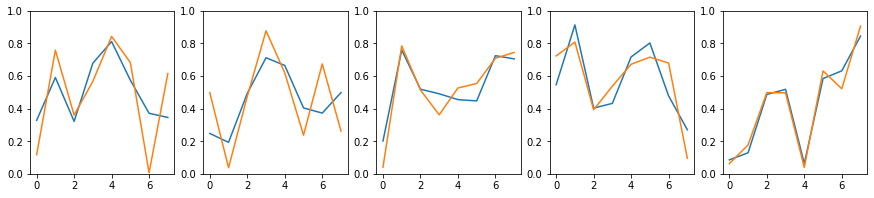

In [101]:
for _ in range(10000):
    layers = [inputs @ weights[0]]
    layers.append(layers[-1] @ weights[1])
    layers.append(layers[-1] @ weights[2])
    layers.append(layers[-1] @ weights[3])
    

    err = (layers[-1]-targets)
    grads[3] = np.einsum('ab,ac->bc',layers[-2],err)

    err = err @ weights[3].T
    grads[2] = np.einsum('ab,ac->bc',layers[-3],err)

    err = err @ weights[2].T
    grads[1] = np.einsum('ab,ac->bc',layers[-4],err)

    err = err @ weights[1].T
    grads[0] = np.einsum('ab,ac->bc',inputs,err)


    weights = [w - g*lr for w,g in zip(weights,grads)]

fig, axs = plt.subplots(1,len(inputs), figsize=(3*len(inputs), 3))
for index,item in enumerate(axs):
    item.set_ylim(0,1)
    item.plot(np.array([((((inputs @ weights[0]) @ weights[1]) @ weights[2]) @ weights[3])[index],targets[index]]).T)

recurrent

In [2083]:
text_data = "dogs like hogs. frogs like logs. bogs like fog."
window = 25
text = window*" " + text_data
letters = {letter:np.eye(len(set(text)))[index] for index,letter in enumerate(set(text))}
data = np.array([letters[n] for n in text])
from scipy.special import softmax
#data = attention
inputs = []
targets = []
batch_size = 30
for n in range(window):
    inputs.append(data[n:n-window-1])
    targets.append(data[n+1:n-window])
    
# shuffled data in batches of 10
shuff = np.random.choice(np.arange(len(inputs[0])), size=len(inputs[0]), replace=False)
shuffled_inputs = np.array([np.array([[t[shuff[n]] for n,_ in enumerate(t)] for t in inputs])[:,n*batch_size:n*batch_size+batch_size] for n in range(0,len(inputs[0])//batch_size)])
shuffled_targets = np.array([np.array([[t[shuff[n]] for n,_ in enumerate(t)] for t in targets])[:,n*batch_size:n*batch_size+batch_size] for n in range(0,len(targets[0])//batch_size)])

wi = np.random.rand(len(inputs[0][0]), len(inputs[0][0]))
wh = np.random.rand(len(inputs[0][0]), len(inputs[0][0]))
wo = np.random.rand(len(inputs[0][0]), len(inputs[0][0]))

def sig(x):
    return 1/(1+np.exp(-x))

def sig_der(x):
    return sig(x)*(1- sig(x))
    
def tanh_der(x):
    return 1 - np.tanh(x)**2


In [2084]:

lr = 0.00232929922807541
error_rate = []
cycle = 0

total errors through time: -4.31457900027604
dogs like hogs. frogs like logs. bogs like fog.
                                              


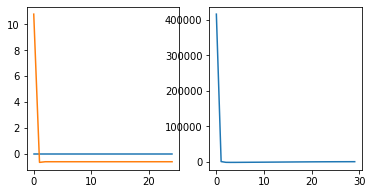

In [2087]:
for _ in range(10):
    error_rate.append(0)
    for epoch in range(100):
        inps = shuffled_inputs[cycle]
        targs = shuffled_targets[cycle]

        w = np.zeros((len(inps[0]),len(inps[0][0])))
        layers = [[np.tanh((w @ wh) + (inps[0] @ wi))]] 
        for n in range(1,len(inps)):
            layers[0].append(np.tanh((layers[0][-1] @ wh) + (inps[n] @ wi)))
            
        layers.append(sig(layers[0] @ wo))

        # backward 
        oerr = (layers[1][-1]-targs[-1])*sig_der(layers[0][-1] @ wo)
        herr = (oerr @ wo.T) * tanh_der((layers[0][-2] @ wh) + (inps[-1] @ wi))
        
        ograd = np.einsum('ab,ac->bc',layers[0][-1],oerr)
        hgrad = np.einsum('ab,ac->bc',layers[0][-2],herr)
        igrad = np.einsum('ab,ac->bc',inps[-1],herr)

        for p in range(2,len(inps)):
            oerr = (layers[1][-p]-targs[-p])*sig_der(layers[0][-p] @ wo)
            herr = ((herr @ wh.T) + (oerr @ wo.T)) * tanh_der((layers[0][-(1+p)] @ wh) + (inps[-p] @ wi))

            ograd = ograd + np.einsum('ab,ac->bc',layers[0][-p],oerr)
            hgrad = hgrad + np.einsum('ab,ac->bc',layers[0][-(1+p)], herr)
            igrad = igrad + np.einsum('ab,ac->bc',inps[-p], herr)

        oerr = (layers[1][0]-targs[0])*sig_der(layers[0][0] @ wo)
        herr = ((herr @ wh.T) + (oerr @ wo.T)) * tanh_der((w @ wh) + (inps[0] @ wi))

        ograd = ograd + np.einsum('ab,ac->bc',layers[0][0],oerr)
        hgrad = hgrad + np.einsum('ab,ac->bc',w, herr)
        igrad = igrad + np.einsum('ab,ac->bc',inps[0], herr)

        # step
        wi = wi - igrad*lr
        wh = wh - hgrad*lr
        wo = wo - ograd*lr
        error_rate[-1] += np.sum([np.sum(l-t) for l,t in zip(layers[1],targs)])
        cycle = (cycle+1)%len(shuffled_inputs)

w = np.zeros((len(inputs[0]),len(inputs[0][0])))
layers = [[np.tanh((w @ wh) + (inputs[0] @ wi))]]
    
for q in range(1,len(inputs)):
    layers[0].append(np.tanh((layers[0][-1] @ wh) + (inputs[q] @ wi)))
layers.append(sig(layers[0] @ wo))
    
current_error = np.array([np.sum(l-t) for l,t in zip(layers[1],targets)])
print(f"total errors through time: {np.sum(current_error)}")

print(text[window:])
print(''.join([check[np.argmin(np.abs(np.sum(v_data - n, 1)))][0] for n in layers[1][-1]]))
#print(''.join([list(enumerate(letters))[np.argmax(n)][1] for n in layers[1][-1]]))

fig, axs = plt.subplots(1,2, figsize=(6, 3))
axs[0].plot(np.array([np.zeros((window)),current_error]).T, label=["target","prediction"])
axs[1].plot(error_rate)

In [2079]:
# attention
h = len(letters)
k = np.random.rand(h,h)
q = np.random.rand(h,h)
v = np.random.rand(h,h)

In [2080]:
for _ in range(100):
    queries = data @ q
    keys = data @ k
    values = data @ v

    scores = queries @ keys.T

    weights = softmax(scores/keys.shape[1]**0.5, axis=1)

    attention = weights @ values

    er = attention - data
    er = weights.T @ er
    et = er @ values.T
    ek = et @ queries
    eq = et @ keys
    g = np.einsum('ab,ac->bc',data,er)
    egk = np.einsum('ab,ac->bc',data,ek)
    egq = np.einsum('ab,ac->bc',data,eq)
    v = v - lr*g
    k = k - lr*egk
    q = q - lr*egq

    check = np.array(list(dict(zip(text,attention)).items()))
    v_data = np.array([n[1] for n in check])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [2082]:
attention[1]

array([4.22538443e-02, 1.40850509e-02, 5.43795244e-09, 1.40847403e-02,
       5.63388313e-02, 4.22538891e-02, 4.22539503e-02, 8.45069735e-02,
       8.45078077e-02, 4.64788942e-01, 1.40844914e-02, 7.04234240e-02,
       4.22545254e-02, 2.81696474e-02])

In [2051]:
et.shape

(72, 14)

In [2052]:
keys.shape

(72, 14)

In [129]:
import torch
import numpy as np
import matplotlib.pyplot as plt

inputs = torch.eye(5)
inputs.names = ('inputs', 'features')
targets = torch.rand(len(inputs),8)

weights = []
biases = []
weights.append((torch.rand(len(inputs[0]), 7, names=('features','outputs')).requires_grad_()))
biases.append((torch.rand(7).requires_grad_()))
weights.append((torch.rand(len(weights[-1][0]), 9).requires_grad_()))
biases.append((torch.rand(9).requires_grad_()))
weights.append((torch.rand(len(weights[-1][0]), 6).requires_grad_()))
biases.append((torch.rand(6).requires_grad_()))
weights.append((torch.rand(len(weights[-1][0]), len(targets[0])).requires_grad_()))
biases.append((torch.rand(len(targets[0])).requires_grad_()))

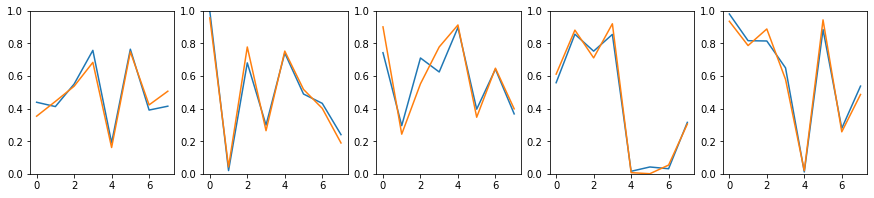

In [131]:
lr = 0.00005
optimizer = torch.optim.SGD([(w) for w in weights]+[(b) for b in biases], lr=lr)

for _ in range(10000):
    optimizer.zero_grad()

    layers = [inputs @ weights[0] + biases[0]]
    layers.append(layers[-1] @ weights[1] + biases[1])
    layers.append(layers[-1] @ weights[2] + biases[2])
    layers.append(layers[-1] @ weights[3] + biases[3])

    loss = (layers[-1] - targets)**2
    loss.backward(gradient=torch.ones(len(inputs),len(targets[0])))
    optimizer.step()

layers = [(inputs @ weights[0] + biases[0])]
layers.append((layers[-1] @ weights[1] + biases[1]))
layers.append((layers[-1] @ weights[2] + biases[2]))
layers.append(layers[-1] @ weights[3] + biases[3])

fig, axs = plt.subplots(1,len(inputs), figsize=(3*len(inputs), 3))
for index,item in enumerate(axs):
    item.set_ylim(0,1)
    item.plot(np.array([layers[-1][index].detach().numpy(),(targets[index]).numpy()]).T)

In [19]:
c = 168
r = 2
cr = c/(2*np.pi)-r
rc = c-r*(2*np.pi)

In [20]:
print((c-rc)/(2*np.pi))
print((r+cr)*(2*np.pi))

2.000000000000002
168.0
